In [3]:
!pip install --upgrade nbformat


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [ ]:
import numpy as np
import pandas as pd




#------------------------------------Plots
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import joblib 



#--------------------Model


from xgboost import XGBClassifier
from modeling_utils import optimize_hyperparameters
from sklearn.metrics import precision_recall_curve, roc_auc_score, classification_report, f1_score, confusion_matrix, roc_curve, auc, precision_score, recall_score, brier_score_loss
import optuna
from modeling_utils import plot_model_evaluation_summary
from sklearn.calibration import calibration_curve, CalibrationDisplay, IsotonicRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score


from modeling_utils import generate_classification_report



import importlib
import modeling_utils
importlib.reload(modeling_utils) 


spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "false")
pd.set_option('display.max_columns', 500)



# General variables

In [5]:
#Training Columns
training_columns = ['home_ownership', 'addr_state', 'dti', 'fico_range_high',
       'all_util', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal',
       'bc_open_to_buy', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op',
       'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc',
       'mths_since_recent_inq', 'num_actv_rev_tl', 'emp_length_numeric',
       'emp_title_final_grouped', 'title_grouped', 'region_median_income',
       'loan_to_income_ratio', 'revolving_balance_to_income_ratio',
       'credit_utilization_manual', 'open_acc_ratio']

# Load data

In [6]:
df_model = pd.read_csv('df_total_woe.csv').drop(['sub_grade','credit_utilization_manual', 'revolving_balance_to_income_ratio', 'mo_sin_rcnt_rev_tl_op', 'int_rate', 'term_numeric', 'verification_status', ], axis=1).rename(columns={'funded_amnt':'loan_amnt'})


print('Data Dimension',df_model.shape)

df_model.head(10)

Data Dimension (1348059, 27)


,id,d_vintage,loan_amnt,home_ownership,annual_inc,addr_state,dti,fico_range_high,all_util,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,mo_sin_old_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_actv_rev_tl,emp_length_numeric,emp_title_final_grouped,title_grouped,region_median_income,loan_to_income_ratio,open_acc_ratio,set,target
0,68407277,2015-12-01,0.258841,0.160306,-0.086534,-0.067006,0.403308,-0.217115,0.106942,-0.405376,0.024740,0.156173,-0.155903,-0.077618,-0.172215,-0.034501,-0.169441,-0.089716,0.084253,0.057010,-0.020484,-0.007931,0.099562,0.457006,-0.007500,train,0.0
1,68355089,2015-12-01,-0.152670,0.160306,-0.030447,-0.101768,0.107425,0.280817,0.106942,-0.405376,0.024740,-0.056093,0.630465,0.061496,-0.205649,0.238651,-0.252891,-0.260049,0.020176,0.057010,0.172054,-0.081017,-0.075997,-0.478301,-0.079388,train,0.0
2,68341763,2015-12-01,-0.152670,0.160306,-0.030447,0.120678,0.282040,0.021937,-0.231529,-0.044784,-0.181297,0.378525,-0.139264,0.037777,0.188066,0.238651,0.391569,0.047732,0.161126,0.057010,-0.313243,-0.081017,0.099562,-0.326559,0.112083,train,0.0
3,68476807,2015-12-01,-0.052293,0.160306,0.262201,-0.067006,-0.164547,0.021937,-0.398292,-0.405376,-0.578527,0.378525,-0.075754,0.061496,-0.098426,0.350769,-0.169441,-0.260049,-0.044349,0.010116,-0.020484,-0.007931,-0.035045,0.387752,0.112083,train,0.0
4,68426831,2015-12-01,-0.052293,-0.168686,-0.212208,0.094121,0.282040,-0.044342,-0.398292,-0.044784,0.456646,-0.176827,-0.194252,-0.392487,0.495469,-0.189779,0.152740,0.000000,0.161126,0.010116,-0.020484,-0.007931,0.054853,-0.478301,-0.226646,train,0.0
5,68476668,2015-12-01,-0.152670,0.160306,0.366531,-0.014735,0.193799,-0.182636,-0.398292,-0.044784,-0.181297,0.378525,-0.347748,0.191351,0.131069,0.238651,-0.076567,0.047732,-0.044349,0.057010,0.012941,-0.007931,0.054853,0.387752,0.037363,train,0.0
6,67275481,2015-12-01,-0.152670,0.160306,0.072425,0.255807,0.059621,0.123391,-0.231529,-0.044784,0.024740,0.109081,0.184215,-0.392487,0.188066,0.169388,0.152740,0.047732,0.237851,0.057010,-0.313243,-0.007931,-0.127956,-0.024098,-0.007500,train,0.0
7,68466926,2015-12-01,0.107043,-0.168686,0.072425,-0.067006,0.193799,-0.084299,0.106942,-0.044784,-0.264431,-0.176827,0.040141,-0.077618,-0.285198,-0.034501,-0.169441,-0.260049,-0.215452,0.010116,0.012941,-0.007931,-0.035045,0.360100,-0.079388,train,0.0
8,68616873,2015-12-01,0.206653,0.160306,-0.155503,0.120678,-0.534175,0.123391,0.106942,-0.044784,-0.079886,0.378525,0.099580,0.137563,0.131069,-0.034501,0.184122,0.047732,0.161126,0.057010,-0.020484,-0.007931,-0.035045,0.168854,0.037363,train,0.0
9,68338832,2015-12-01,0.341164,0.160306,-0.030447,-0.059460,-0.534175,0.123391,-0.231529,-0.044784,0.024740,0.156173,0.040141,0.137563,-0.205649,0.238651,0.069577,0.231346,-0.374405,0.010116,-0.313243,-0.081017,-0.035045,0.586774,-0.181678,train,0.0


# Data Splitting

In [7]:
X_train_i = df_model[df_model['set']=='train'].drop(['target', 'set'], axis=1).set_index(['id',	'd_vintage'])
y_train_i = df_model[df_model['set']=='train'].set_index(['id',	'd_vintage'])[['target']]


X_test = df_model[df_model['set']=='test'].drop(['target', 'set'], axis=1).set_index(['id',	'd_vintage'])
y_test = df_model[df_model['set']=='test'].set_index(['id',	'd_vintage'])[['target']]




X_train, X_calib, y_train, y_calib = train_test_split(
    X_train_i, y_train_i,
    test_size=0.3,      
    random_state=42,
    stratify=y_train_i 
)

print('Training data dimension', X_train.shape, y_train.shape)

print('Calbrating data dimension', X_calib.shape, y_calib.shape)

print('Test data dimension', X_test.shape, y_test.shape)

Training data dimension (702962, 23) (702962, 1)
Calbrating data dimension (301270, 23) (301270, 1)
Test data dimension (343827, 23) (343827, 1)


# Finding the best Parameters

In [ ]:

def objective_to_reach_70_auc(trial, X, y):
    """
    An Optuna objective function with a more aggressive search space
    and robust early stopping to maximize the chances of reaching an AUC of 0.70.
    """
    
    # --- 1. Define a more aggressive search space ---
    # We are exploring deeper trees and lower learning rates.
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'use_label_encoder': False,
        'n_jobs': -1,
        'random_state': 42,
        
        'max_depth': trial.suggest_int('max_depth', 3, 12),          # Explore deeper trees
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.5), # Focus on lower learning rates
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10), # Add this for more control
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        
        'scale_pos_weight': (y.value_counts()[0] / y.value_counts()[1])
    }
    
    # --- 2. Perform manual Cross-Validation ---
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []

    for train_idx, val_idx in cv.split(X, y):
        X_train_fold, y_train_fold = X.iloc[train_idx], y.iloc[train_idx]
        X_val_fold, y_val_fold = X.iloc[val_idx], y.iloc[val_idx]

        # --- 3. Use more robust training parameters ---
        model = XGBClassifier(
            n_estimators=2000,          # Increased max trees for low learning rates
            **params,
            early_stopping_rounds=20    # Increased patience
        )

        model.fit(
            X_train_fold, y_train_fold,
            eval_set=[(X_val_fold, y_val_fold)], 
            verbose=False                      
        )
        
        preds = model.predict_proba(X_val_fold)[:, 1]
        scores.append(roc_auc_score(y_val_fold, preds))

    return np.mean(scores)

# --- 4. Run the optimization with more trials ---
print("Starting aggressive hyperparameter optimization for XGBoost...")
study = optuna.create_study(direction='maximize')
# Increased n_trials to 100 for a more thorough search
study.optimize(lambda trial: objective_to_reach_70_auc(trial, X_train, y_train), n_trials=100)

# --- Print the results ---
best_xgb_params = study.best_params
print(f"\nOptimization complete.")
print(f"Best cross-validated AUC: {study.best_value:.4f}")
print("Best parameters found:")
for key, value in best_xgb_params.items():
    print(f"  {key}: {value}")


In [ ]:

best_params_from_optuna = {
    'learning_rate': 0.02638957279655627,
    'max_depth': 4,
    'subsample': 0.9246057495595279,
    'colsample_bytree':0.8191763291263932,
    'min_child_weight': 7,
    'gamma': 1.6026470854822383e-08,
    'reg_alpha': 0.2697973767118685,
    'reg_lambda': 0.0007433987038489679,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'use_label_encoder': False,
    'n_jobs': -1,
    'random_state': 42,
    'scale_pos_weight': (y_train.value_counts()[0] / y_train.value_counts()[1])
}


X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42, stratify=y_train
)


model_for_tuning_trees = XGBClassifier(
    n_estimators=2000, 
    **best_params_from_optuna
)

model_for_tuning_trees.fit(
    X_train_sub, 
    y_train_sub, 
    eval_set=[(X_val, y_val)],
    verbose=False
)

results = model_for_tuning_trees.evals_result()
val_auc = np.array(results['validation_0']['auc'])
x_axis = np.arange(len(val_auc))


optimal_n_estimators = 910
final_auc_score = val_auc[optimal_n_estimators - 1] # Get the score at that point

print(f"Manual selection of optimal trees.")
print(f"The chosen number of trees is: {optimal_n_estimators}")
print(f"At this point, the validation AUC was: {final_auc_score:.4f}")

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(x_axis, val_auc, label='Validation Set AUC')

ax.axvline(x=optimal_n_estimators, color='r', linestyle='--', label=f'Chosen Optimum: {optimal_n_estimators} trees')
ax.legend()
ax.set_ylabel('AUC Score')
ax.set_xlabel('Number of Trees (n_estimators)')
ax.set_title('XGBoost Learning Curve - Manual Optimum Selection')
plt.grid(True)
plt.show()

# Training the Xgboost model with the best parameters

In [ ]:
final_xgb_params = best_params_from_optuna.copy()
final_xgb_params['n_estimators'] = optimal_n_estimators



print('Final parameters:', final_xgb_params)



print(f"\nTraining the final XGBoost model with {optimal_n_estimators} trees...")
final_xgb_model = XGBClassifier(**final_xgb_params)
final_xgb_model.fit(X_train, y_train)
print("Training complete!")


In [11]:
X_train.columns

Index(['loan_amnt', 'home_ownership', 'annual_inc', 'addr_state', 'dti',
       'fico_range_high', 'all_util', 'inq_last_12m', 'acc_open_past_24mths',
       'avg_cur_bal', 'bc_open_to_buy', 'mo_sin_old_rev_tl_op',
       'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc',
       'mths_since_recent_inq', 'num_actv_rev_tl', 'emp_length_numeric',
       'emp_title_final_grouped', 'title_grouped', 'region_median_income',
       'loan_to_income_ratio', 'open_acc_ratio'],
      dtype='object')

# Model Calibration

--- Getting probabilities on the calibration set ---
--- Training the isotonic calibrator ---
Calibrator trained.

--- Evaluating and visualizing on the Test set ---


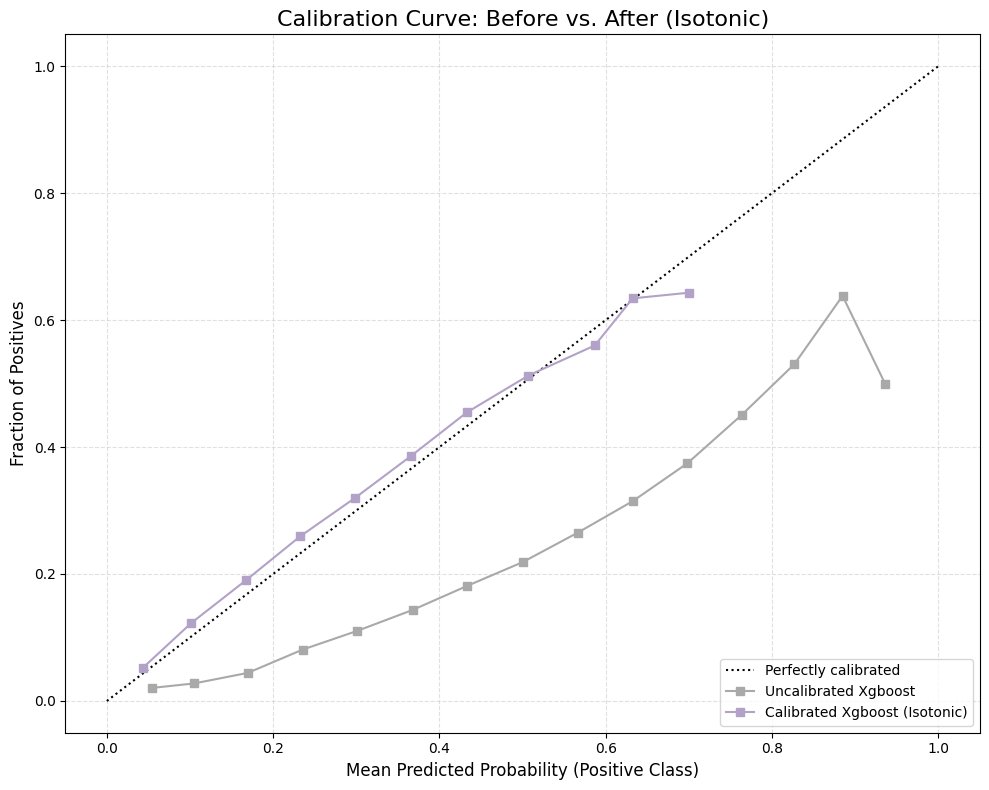


--- AUC Comparison on Test Set ---
AUC of uncalibrated model: 0.6960
AUC of calibrated model:    0.6959


In [15]:
colors = {
    "main_purple": "#b3a2c7",
    "medium_grey": "#a9a9a9"
}


print("--- Getting probabilities on the calibration set ---")
y_pred_calib_proba = final_xgb_model.predict_proba(X_calib)[:, 1]

print("--- Training the isotonic calibrator ---")
y_calib_flat = y_calib.values.ravel()
xgboost_isotonic_calibrator = IsotonicRegression(out_of_bounds='clip')
xgboost_isotonic_calibrator.fit(y_pred_calib_proba, y_calib_flat)
print("Calibrator trained.")


print("\n--- Evaluating and visualizing on the Test set ---")
y_pred_test_uncalibrated_proba = final_xgb_model.predict_proba(X_test)[:, 1]
y_pred_test_calibrated_proba = xgboost_isotonic_calibrator.transform(y_pred_test_uncalibrated_proba)
fig, ax = plt.subplots(figsize=(10, 8))


CalibrationDisplay.from_predictions(
    y_test,
    y_pred_test_uncalibrated_proba,
    n_bins=15,
    name='Uncalibrated Xgboost',
    ax=ax,
    strategy='uniform',
    color=colors["medium_grey"]
)


CalibrationDisplay.from_predictions(
    y_test,
    y_pred_test_calibrated_proba,
    n_bins=15,
    name='Calibrated Xgboost (Isotonic)',
    ax=ax,
    strategy='uniform',
    color=colors["main_purple"]
)


ax.set_title('Calibration Curve: Before vs. After (Isotonic)', fontsize=16)
ax.set_xlabel("Mean Predicted Probability (Positive Class)", fontsize=12)
ax.set_ylabel("Fraction of Positives", fontsize=12)


ax.grid(True, linestyle='--', color='lightgray', alpha=0.7)

plt.tight_layout() 
plt.show()


auc_test_uncalibrated = roc_auc_score(y_test, y_pred_test_uncalibrated_proba)
auc_test_calibrated = roc_auc_score(y_test, y_pred_test_calibrated_proba)

print(f"\n--- AUC Comparison on Test Set ---")
print(f"AUC of uncalibrated model: {auc_test_uncalibrated:.4f}")
print(f"AUC of calibrated model:    {auc_test_calibrated:.4f}")

# Feature Importance

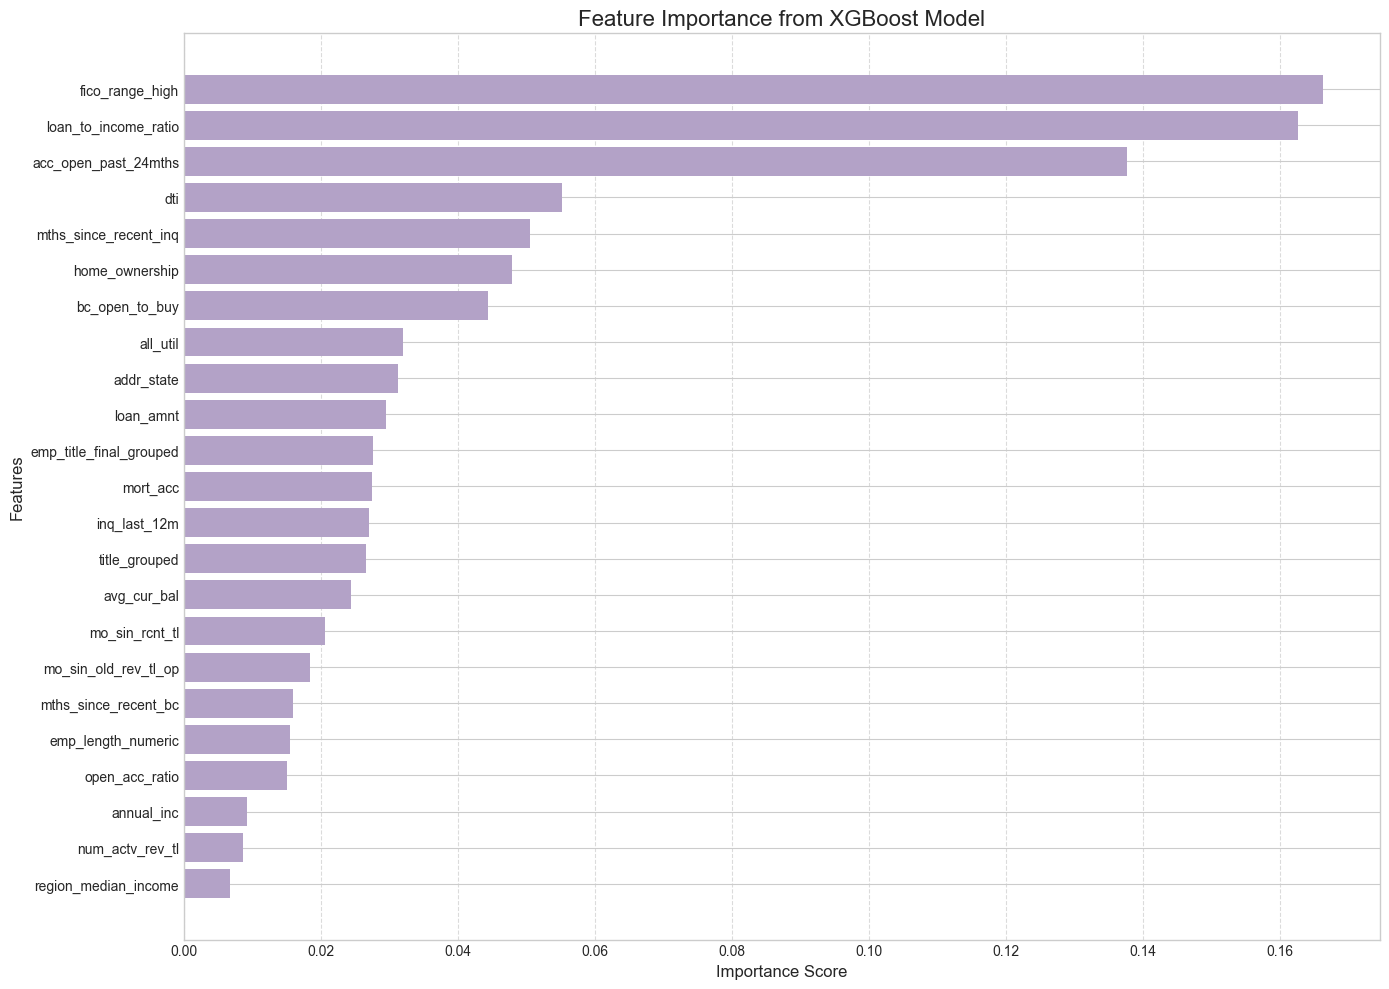


Top 10 Most Important Features:
              feature  importance
      fico_range_high    0.166264
 loan_to_income_ratio    0.162580
 acc_open_past_24mths    0.137573
                  dti    0.055199
mths_since_recent_inq    0.050555
       home_ownership    0.047884
       bc_open_to_buy    0.044395
             all_util    0.031994
           addr_state    0.031197
            loan_amnt    0.029548


In [16]:
main_purple = "#b3a2c7"



importances = final_xgb_model.feature_importances_
feature_names = X_train.columns


feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})


feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)


plt.style.use('seaborn-v0_8-whitegrid') 
fig, ax = plt.subplots(figsize=(14, 10))


top_20_features = feature_importance_df
ax.barh(
    top_20_features['feature'][::-1], 
    top_20_features['importance'][::-1], 
    color=main_purple
)


ax.set_title('Feature Importance from XGBoost Model', fontsize=16)
ax.set_xlabel('Importance Score', fontsize=12)
ax.set_ylabel('Features', fontsize=12)
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)


ax.grid(axis='x', linestyle='--', alpha=0.7)


plt.tight_layout()
plt.show()


print("\nTop 10 Most Important Features:")
print(feature_importance_df.head(10).to_string(index=False))

# Results

### Precicion-Recall curve

In [17]:

uncalibrated_proba = final_xgb_model.predict_proba(X_calib)[:, 1]

y_pred_proba = xgboost_isotonic_calibrator.predict(uncalibrated_proba)


precisions, recalls, thresholds = precision_recall_curve(y_calib, y_pred_proba)


results_df = pd.DataFrame({
    'Threshold': thresholds,
    'Precision': precisions[:-1],
    'Recall': recalls[:-1]
})

# Add F1-Score for a more balanced view
# Avoid division by zero if precision and recall are both 0
results_df['F1-Score'] = 2 * (results_df['Precision'] * results_df['Recall']) / \
                        (results_df['Precision'] + results_df['Recall']).replace(0, 1e-9)

print("--- Threshold Analysis Results ---")

display(results_df.sort_values(by='F1-Score', ascending=False).head(10))



fig = make_subplots(specs=[[{"secondary_y": True}]])


fig.add_trace(
    go.Scatter(x=results_df['Threshold'], y=results_df['Precision'], name='Precision', line=dict(color='black')),
    secondary_y=False,
      
)
fig.add_trace(
    go.Scatter(x=results_df['Threshold'], y=results_df['Recall'], name='Recall', line=dict(color='#8e79a8')),
    secondary_y=False,
)


fig.add_trace(
    go.Scatter(x=results_df['Threshold'], y=results_df['F1-Score'], name='F1-Score', line=dict(dash='dot')),
    secondary_y=False,
)


best_f1_row = results_df.loc[results_df['F1-Score'].idxmax()]
best_threshold = best_f1_row['Threshold']
best_f1_score = best_f1_row['F1-Score']

fig.add_vline(x=best_threshold, line_width=1, line_dash="dash", line_color="red",
              annotation_text=f'Best F1-Score Threshold: {best_threshold:.2f}',
              annotation_position="bottom right")


fig.update_layout(
    title_text='Precision, Recall, and F1-Score vs. Decision Threshold',
    xaxis_title='Decision Threshold',
    yaxis_title='Score',
    legend_title='Metric',
    template='plotly_white'
)

fig.show()

--- Threshold Analysis Results ---


,Threshold,Precision,Recall,F1-Score
97,0.206864,0.305527,0.603333,0.405639
96,0.201372,0.303689,0.610476,0.405605
98,0.222017,0.307383,0.595791,0.405538
95,0.200391,0.299319,0.628272,0.405466
94,0.199238,0.299316,0.628272,0.405464
93,0.198695,0.299314,0.628272,0.405462
92,0.198288,0.296469,0.640350,0.405295
91,0.194805,0.296406,0.640610,0.405288
99,0.223042,0.309939,0.583278,0.404786
90,0.193845,0.290569,0.665896,0.404591


In [20]:


def generate_classification_metrics(y_true, y_pred_proba, threshold, dataset_name="Test"):
    """
    Calculates a comprehensive set of classification metrics for a given threshold.
    This version includes debugging prints to diagnose issues.

    Args:
        y_true: True labels.
        y_pred_proba: Predicted probabilities for the positive class.
        threshold: The decision threshold to use.
        dataset_name: Name of the dataset ('Train' or 'Test') for printing.

    Returns:
        A dictionary containing all the calculated metrics.
    """
    # --- CRITICAL: Ensure alignment and correct data types ---
    y_true_np = np.asarray(y_true).astype(int)
    y_pred_proba_np = np.asarray(y_pred_proba).astype(float)
    
    # Apply the custom threshold
    y_pred = (y_pred_proba_np >= threshold).astype(int)
    
    # --- START DEBUGGING BLOCK ---
    print(f"\n--- Debugging Info for '{dataset_name}' Set ---")
    print(f"Threshold used: {threshold:.4f}")
    print(f"Shape of y_true_np: {y_true_np.shape}")
    print(f"Shape of y_pred: {y_pred.shape}")
    print(f"Unique values in y_true_np: {np.unique(y_true_np)}")
    print(f"Unique values in y_pred: {np.unique(y_pred, return_counts=True)}")
    
    # Calculate and print the confusion matrix
    cm = confusion_matrix(y_true_np, y_pred)
    print("Confusion Matrix:")
    print(cm)
    print("---------------------------------------\n")
    # --- END DEBUGGING BLOCK ---

    # Now, calculate metrics as before
    report_dict = classification_report(y_true_np, y_pred, output_dict=True, zero_division=0)
    
    auc = roc_auc_score(y_true_np, y_pred_proba_np)
    gini = 2 * auc - 1
    brier = brier_score_loss(y_true_np, y_pred_proba_np)
    
    class_0_metrics = report_dict.get('0', {'precision': 0, 'recall': 0, 'f1-score': 0})
    class_1_metrics = report_dict.get('1', {'precision': 0, 'recall': 0, 'f1-score': 0})
    
    metrics = {
        "AUC": auc, "Gini": gini, "Brier Score": brier,
        "Precision (Class 0)": class_0_metrics['precision'],
        "Recall (Class 0)": class_0_metrics['recall'],
        "F1-Score (Class 0)": class_0_metrics['f1-score'],
        "Precision (Class 1)": class_1_metrics['precision'],
        "Recall (Class 1)": class_1_metrics['recall'],
        "F1-Score (Class 1)": class_1_metrics['f1-score'],
        "Accuracy": report_dict['accuracy']
    }
    
    return metrics


optimal_threshold = 0.19


test_uncalibrated_proba =  final_xgb_model.predict_proba(X_test)[:, 1]
test_pred_proba = xgboost_isotonic_calibrator.predict(test_uncalibrated_proba)

train_uncalibrated_proba =  final_xgb_model.predict_proba(X_train)[:, 1]
train_pred_proba = xgboost_isotonic_calibrator.predict(train_uncalibrated_proba)

test_metrics = generate_classification_metrics(y_test, test_pred_proba, optimal_threshold)


train_metrics = generate_classification_metrics(y_train, train_pred_proba, optimal_threshold, dataset_name="Train")
test_metrics = generate_classification_metrics(y_test, test_pred_proba, optimal_threshold, dataset_name="Test")


optimal_threshold_row = results_df.loc[results_df['F1-Score'].idxmax()]
optimal_threshold = optimal_threshold_row['Threshold']
print(f"Using Optimal Threshold (max F1-Score): {optimal_threshold:.4f}\n")




# --- STEP 3: Display the results in a clean comparison table ---
comparison_df = pd.DataFrame({
    'Train': train_metrics,

    'Test': test_metrics
})

print("--- Classification Metrics Comparison with Optimal Threshold ---")
display(comparison_df)


--- Debugging Info for 'Test' Set ---
Threshold used: 0.1900
Shape of y_true_np: (343827, 1)
Shape of y_pred: (343827,)
Unique values in y_true_np: [0 1]
Unique values in y_pred: (array([0, 1]), array([176120, 167707]))
Confusion Matrix:
[[153231 113081]
 [ 22889  54626]]
---------------------------------------


--- Debugging Info for 'Train' Set ---
Threshold used: 0.1900
Shape of y_true_np: (702962, 1)
Shape of y_pred: (702962,)
Unique values in y_true_np: [0 1]
Unique values in y_pred: (array([0, 1]), array([394252, 308710]))
Confusion Matrix:
[[350725 217974]
 [ 43527  90736]]
---------------------------------------


--- Debugging Info for 'Test' Set ---
Threshold used: 0.1900
Shape of y_true_np: (343827, 1)
Shape of y_pred: (343827,)
Unique values in y_true_np: [0 1]
Unique values in y_pred: (array([0, 1]), array([176120, 167707]))
Confusion Matrix:
[[153231 113081]
 [ 22889  54626]]
---------------------------------------

Using Optimal Threshold (max F1-Score): 0.2069

--- Cl

,Train,Test
AUC,0.701956,0.695909
Gini,0.403911,0.391818
Brier Score,0.141725,0.160271
Precision (Class 0),0.889596,0.870037
Recall (Class 0),0.616715,0.575382
F1-Score (Class 0),0.728438,0.692676
Precision (Class 1),0.293920,0.325723
Recall (Class 1),0.675808,0.704715
F1-Score (Class 1),0.409668,0.445523
Accuracy,0.628001,0.604539


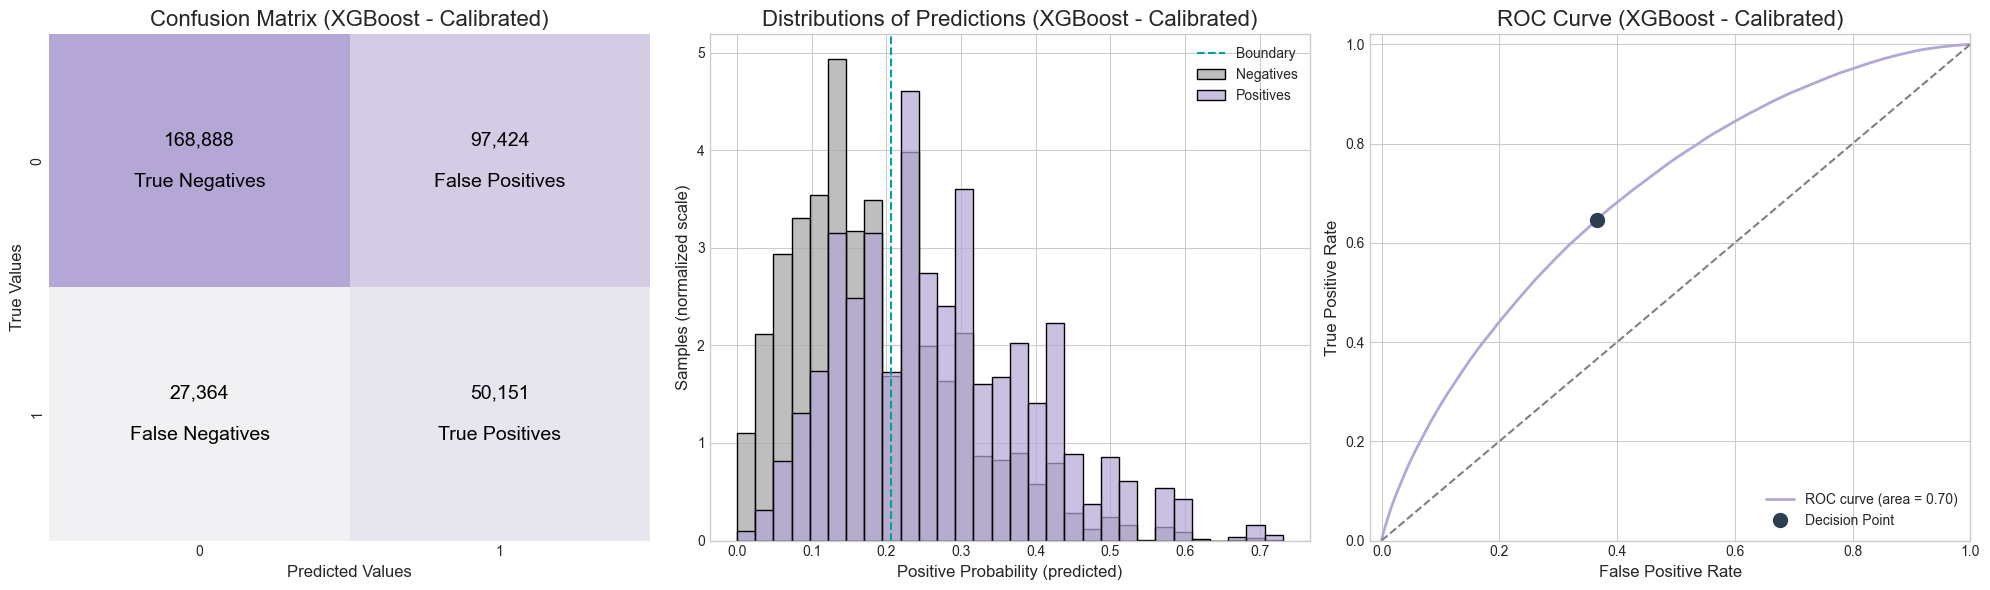

In [21]:
plot_model_evaluation_summary(
    base_model=final_xgb_model,        
    X_data=X_test,
    y_true=y_test.values.ravel(),
    calibrator=xgboost_isotonic_calibrator,
    model_name='XGBoost',
    custom_color='#b4a7d6',
    threshold=optimal_threshold   
)

# Saving model

In [224]:
joblib.dump(final_xgb_model, 'final_xgboost_model.joblib')

joblib.dump(xgboost_isotonic_calibrator, 'xgboost_isotonic_calibrator.joblib')

['xgboost_isotonic_calibrator.joblib']

In [225]:
X_train.shape

(702962, 23)